cpu


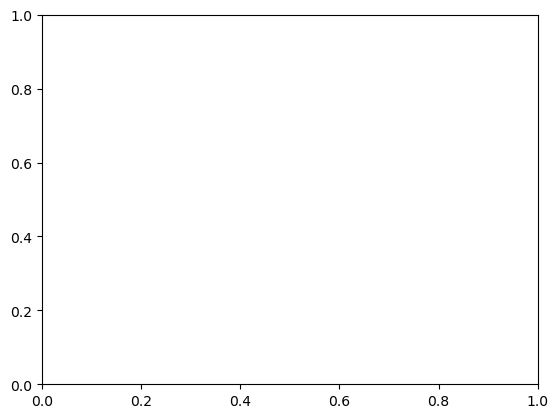

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
import utils
from data_utils import CustomDataset
from MLP_utils import load_model, save_model, fix_seed, SimpleMLP, LNLoss
import os
import pandas as pd
import pickle

fix_seed(utils.SEED)

device = torch.device("cpu")
print(device)

brands_in_csv_filename = [
    "ad",
    "brabantsdagblad",
    "destentor",
    "nu",
    "parool",
    "trouw",
    "volkskrant",
]


plt.rcParams['figure.facecolor'] = ('white') 
plt.gca().set_facecolor('white')


plt.rcParams["figure.figsize"] = (6.8,7)
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
model, config = load_model('last_run', device=device)

In [5]:
config

{'criterion': MSELoss(),
 'optimizer': 'adam',
 'weight_decay': 0.00039931079168018907,
 'depth': 3,
 'width': 256,
 'lr': 7.069564548473013e-05,
 'batch_size': 1024,
 'max_epochs': 50,
 'patience': 3,
 'batchnorm': False,
 'dropout': 0.09829492149373525,
 'input_size': 4634,
 'filenames_features': ['brand_ohe.pt',
  'publication_timestamp_emb.pt',
  'publication_weekday_ohe.pt',
  'num_words.pt',
  'num_paragraph.pt',
  'main_section_emb.pt',
  'subsections_emb.pt',
  'user_needs.pt',
  'lda_topics.pt',
  'iptc_topics_level_0.pt',
  'iptc_topics_level_1.pt',
  'title_emb.pt',
  'author_ohe.pt',
  'labels_emb.pt',
  'time_indications_mentioned_emb.pt']}

In [7]:
brands = utils.ALL_BRANDS


customdataset_kwargs = dict(
                        brands=brands, 
                        filenames_features=config["filenames_features"], 
                        dirpath_extracted_features=utils.DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=True, 
                        center_target=True,
                        filter_uniform_features=False, 
                        max_datapoints=None)
try:
    dataset = CustomDataset(**customdataset_kwargs)
except torch.cuda.OutOfMemoryError as e:
    print("There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.")
    customdataset_kwargs['device'] = torch.device(device)
    dataset = CustomDataset(**customdataset_kwargs)
    
dataset.features.shape[1], dataset.device

/home/casper/Documents/leren en beslissen/LB_Project/data_utils.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.target = torch.concat([torch.load(os.path.join(dirp

(4634, device(type='cpu'))

In [8]:
with open(os.path.join(utils.DIRPATH_INDICES, 'train_dataset_indices.pkl'), 'rb') as f:
    train_dataset_indices = pickle.load(f)

with open(os.path.join(utils.DIRPATH_INDICES, 'val_dataset_indices.pkl'), 'rb') as f:
    val_dataset_indices = pickle.load(f)

with open(os.path.join(utils.DIRPATH_INDICES, 'test_dataset_indices.pkl'), 'rb') as f:
    test_dataset_indices = pickle.load(f)

In [9]:
with torch.no_grad():
    model.eval()
    # metric = nn.MSELoss(reduction='none')
    metric = nn.L1Loss(reduction='none')

    y_test = dataset[test_dataset_indices][1]
    y_pred_test = model(dataset[test_dataset_indices][0])
    
    metric_score_test = metric(y_pred_test, y_test)
    metric_score_test = metric_score_test.squeeze()
    y_pred_test = y_pred_test.squeeze()

In [10]:
test_sort = torch.sort(metric_score_test, dim=0, descending=True)
test_sort_indices = torch.tensor(test_dataset_indices)[test_sort.indices]
test_sort_values = test_sort.values

test_pred = y_pred_test[test_sort.indices]
test_pred_hours = torch.exp(test_pred + dataset.centering_shift)

In [11]:
data_pd = pd.concat([pd.read_csv(os.path.join(utils.DIRPATH_DATA, f"uva-relevance-windows-{brand_in_csv_filename}.csv"), sep=";")
                     for brand_in_csv_filename in brands_in_csv_filename], ignore_index=True)

In [12]:
# Amount of errors you want to see
n_errors = 5

# biggest n errors
biggest_errors = test_sort_values[:n_errors]
# smallest n errors
smallest_errors = test_sort_values[-n_errors:]

In [13]:
test_pred_hours[5000]

tensor(13.7538)

In [14]:
test_pred_hours[5000]
data_pd.iloc[5000]

article_id                                                              e1f67ff
brand                                                                        ad
publication_timestamp                                 2024-05-09 18:29:35+00:00
publication_weekday                                                   donderdag
title                         Woonbedrijf onderzoekt verkoop duizend woninge...
first_paragraph               EINDHOVEN - Woonbedrijf wil de mogelijkheid on...
full_body                     EINDHOVEN - Woonbedrijf wil de mogelijkheid on...
num_words                                                                   513
num_paragraphs                                                               11
author_ids                             ['9ba02916-54c6-3f13-abbf-10373f0c166c']
labels                                                                      NaN
main_section                                                              regio
subsections                             

In [15]:
# predictions of n biggest errors
test_pred_hours[:n_errors]


tensor([13.8664, 15.6637, 15.5725, 26.5722, 17.7245])

In [16]:
# n articles with biggest error
data_pd.iloc[test_sort_indices[:n_errors]]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
176951,6320875,nu,2024-07-16 07:40:53+00:00,dinsdag,Zorginstituut adviseert om afslankmiddel Wegov...,Het Zorginstituut Nederland adviseert minister...,Het Zorginstituut Nederland adviseert minister...,347,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,binnenland,"{'geef_me_context': 0.0006683157407678664, 'he...",{'afval_en_milieuproblematiek': 0.000470316153...,{'gezondheid': 1},"{'ziekten en aandoeningen': 0.7924, 'gezondhei...",NaN,452.0
183412,6329790,nu,2024-09-28 06:50:00+00:00,zaterdag,Bergwijn maakt zijn eerste doelpunt voor Al It...,Steven Bergwijn heeft vrijdagavond zijn eerste...,Steven Bergwijn heeft vrijdagavond zijn eerste...,173,1,['3c3127e2-b2f6-33b5-a644-b246440e7af2'],"steven bergwijn,voetbal",sport,voetbal,"{'geef_me_context': 0.0003729545860551298, 'he...",{'afval_en_milieuproblematiek': 0.000887690461...,"{'sport': 0.653, 'samenleving': 0.3652, 'leven...","{'wedstrijddiscipline': 0.6183, 'vrije tijd': ...",vrijdagavond,460.0
113590,449fd9b,brabantsdagblad,2024-07-15 16:11:35+00:00,maandag,Realityster Mark Gillis na zeventien dagen van...,"OMMEL - Mark Gillis, de zoon van realityster e...","OMMEL - Mark Gillis, de zoon van realityster e...",72,2,['a458bc2e-ec71-358d-987d-2608b60509ca'],NaN,regio,brabant,"{'geef_me_context': 0.0002837566134985536, 'he...",{'afval_en_milieuproblematiek': 0.001387650961...,"{'gezondheid': 0.8497, 'wetenschap en technolo...","{'ziekten en aandoeningen': 0.5048, 'gezondhei...",NaN,345.0
176599,6320378,nu,2024-07-11 14:59:00+00:00,donderdag,Mensen worden niet meer getest op chlamydia al...,De GGD gaat vanaf 2025 niet langer mensen test...,De GGD gaat vanaf 2025 niet langer mensen test...,424,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,binnenland,"{'geef_me_context': 0.0004959646030329168, 'he...",{'afval_en_milieuproblematiek': 0.000401869212...,{'gezondheid': 0.8814},{'gezondheidsbehandeling': 0.7319},donderdag,558.0
183671,6330109,nu,2024-10-01 10:18:53+00:00,dinsdag,Nederland en België aan kop met hoogste inflat...,Van alle eurolanden hebben Nederland en België...,Van alle eurolanden hebben Nederland en België...,199,1,['9d673d03-cc3b-3dc3-b03a-a2c60b730722'],"europese unie,economie,inflatie",economie,economie,"{'geef_me_context': 0.0004973853938281536, 'he...",{'afval_en_milieuproblematiek': 0.001020623138...,"{'economie, zaken en financiën': 0.8808}",{'economie': 0.8808},maand,372.0


In [17]:
# predictions of n smallest errors
test_pred_hours[-n_errors:]

tensor([113.0272,  27.9945,  60.0117,  33.9954,  21.9994])

In [18]:
# n articles with smallest error
data_pd.iloc[test_sort_indices[-n_errors:]]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
201314,1c577d8,trouw,2024-10-04 15:56:37+00:00,vrijdag,Ook een herfstontkenner? Loethe Olthuis weet n...,"Zucht, zelfs een herfstontkenner als ik kan er...","Zucht, zelfs een herfstontkenner als ik kan er...",507,10,['0b380109-ba6c-3ca9-a269-5457b9c5cebe'],"column,loethe olthuis",NaN,NaN,"{'geef_me_context': 0.0015735314227640629, 'he...",{'afval_en_milieuproblematiek': 0.000438401766...,"{'wetenschap en technologie': 0.7582, 'economi...","{'economische sector': 0.7784, 'natuurwetensch...",jaar,113.0
23614,0713d12,ad,2024-06-10 12:30:15+00:00,maandag,Ellaha (26) pendelt voor werk tussen Antwerpen...,Als kind moest ze huis en haard in Afghanistan...,Als kind moest ze huis en haard in Afghanistan...,894,19,['38b93514-0df6-3468-9e2e-e4903abbc4a4'],utrecht helpt,NaN,NaN,"{'geef_me_context': 0.002823220333084464, 'hel...",{'afval_en_milieuproblematiek': 0.000284909852...,"{'economie, zaken en financiën': 0.5185, 'same...","{'familie': 0.4273, 'economische sector': 0.51...",NaN,28.0
42625,8b97a40,ad,2024-07-16 09:06:13+00:00,dinsdag,"Samen energie opwekken, delen en opslaan: pilo...","Een nieuw proefproject, Energiepolder, gaat va...","Een nieuw proefproject, Energiepolder, gaat va...",172,3,['96893eca-34f0-3cb4-bce9-9a83c4acd780'],NaN,regio,hoeksche-waard,"{'geef_me_context': 0.0004705544270109385, 'he...",{'afval_en_milieuproblematiek': 0.000878887833...,"{'wetenschap en technologie': 0.838, 'millieu'...","{'economische sector': 0.9717, 'natuurwetensch...",NaN,60.0
38717,a389af2,ad,2024-07-08 13:00:42+00:00,maandag,Bij ‘flapdrol’ gaat de liefde vóór zijn studie...,"‘Meneer, het gaat goed komen. Echt.’ Een stude...","‘Meneer, het gaat goed komen. Echt.’ Een stude...",462,7,['66c1526a-4232-32a6-909b-d8fa6394a0ff'],uit de klas,regio,alphen-aan-den-rijn,"{'geef_me_context': 0.4942280650138855, 'help_...",{'afval_en_milieuproblematiek': 0.008427522145...,"{'opleiding': 0.5109, 'wetenschap en technolog...",{'sociale wetenschappen': 0.3349},NaN,34.0
15308,ddbb38f,ad,2024-05-27 13:08:59+00:00,maandag,"Als man nog een keer met broodmes dreigt, moet...",De 40-jarige Doetinchemmer die in verwarde sta...,De 40-jarige Doetinchemmer die in verwarde sta...,202,5,['672f073b-e5d6-3cec-98e3-6d5d858ae389'],NaN,regio,doetinchem,"{'geef_me_context': 0.0005479779792949557, 'he...",{'afval_en_milieuproblematiek': 0.000817780848...,"{'misdaad, recht en gerechtigheid': 0.7614}","{'politie': 0.7614, 'wet': 0.7098, 'rechterlij...",NaN,22.0


In [19]:
# Full titles smallest errors
for title in data_pd.iloc[test_sort_indices[-n_errors:]]["title"]:
    print(title)

Ook een herfstontkenner? Loethe Olthuis weet nog wel wat klusjes die uw gemoed én tuin ten goede komen
Ellaha (26) pendelt voor werk tussen Antwerpen en Nieuwegein: wie helpt haar aan een huis?
Samen energie opwekken, delen en opslaan: pilot 'Energiepolder' van start in Hoeksche Waard
Bij ‘flapdrol’ gaat de liefde vóór zijn studie: veel studenten zijn bezig met het nu, niet hun toekomst
Als man nog een keer met broodmes dreigt, moet hij de gevangenis in


In [20]:
test_dataset = Subset(dataset, indices=test_dataset_indices)

In [21]:
import math
target_test = test_dataset.dataset[test_dataset.indices][1] + dataset.centering_shift
baseline = torch.full_like(target_test, math.log(24))
baseline_metric = metric(target_test, baseline).squeeze()
print(baseline_metric.mean(), baseline_metric.std())

tensor(0.5815) tensor(0.5782)


In [22]:
dif = metric_score_test - baseline_metric
baseline_beter = dif[dif>0]
model_better = dif[dif<=0]

In [23]:
model_better.shape[0] / dif.shape[0]

0.5937880633373934

tensor(-0.3266) tensor(0.3279) tensor(-3.5584e-05)


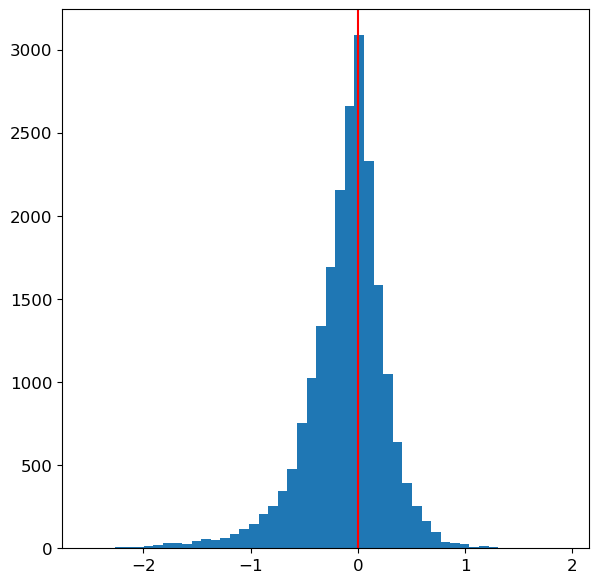

In [24]:
print(model_better.mean(), model_better.std(), model_better.max())
plt.hist(dif,bins=50)
plt.axvline(x=0, c='r')
plt.show()

In [27]:
# random forest data loading
dataset_forest = pd.concat([pd.read_csv("./y_real.csv"), pd.read_csv("./y_pred.csv")], axis=1)
dataset_forest = dataset_forest.loc[:, ~dataset_forest.columns.duplicated()]
print(dataset_forest)
y_pred_test_forest = dataset_forest["pred_y"]
y_pred_test_forest = torch.tensor(y_pred_test_forest)
y_test_forest = dataset_forest["real_y"]
y_test_forest = torch.tensor(y_test_forest)
test_dataset_indices_forest = dataset_forest["Indices"]

with torch.no_grad():
    metric = nn.L1Loss(reduction='none')
    
    metric_score_test_forest = metric(y_pred_test_forest, y_test_forest)
    metric_score_test_forest = metric_score_test_forest.squeeze()
    y_pred_test_forest = y_pred_test_forest.squeeze()

       Indices    real_y    pred_y
0        42181  1.945910  3.512141
1       107897  3.401197  3.250251
2       120012  1.945910  2.768515
3        47320  3.663562  3.665859
4       212144  3.496508  3.955008
...        ...       ...       ...
21341    60863  3.988984  3.506308
21342    19069  3.091042  3.372744
21343    59716  4.127134  3.505559
21344   186361  3.433987  4.199728
21345   132837  4.574711  3.150620

[21346 rows x 3 columns]


brands:
0.AD: 9987
1.Brabants Dagblad: 3441
2.DeStentor: 3595
3.NU: 1640
4.Het Parool: 762
5.Trouw: 832
6.De Volkskrant: 1089

weekdays:
0.Monday: 3448
1.Tuesday: 3593
2.Wednesday: 3280
3.Thursday: 2216
4.Friday: 2422
5.Saturday: 3142
6.Sunday: 3245

user_needs:
0.geef me context: 3980
1.help me: 1461
2.hou me op de hoogte: 11795
3.raak me verbind me: 2527
4.vermaak me: 1583

LDA_topics:
0.afval_en_milieuproblematiek: 20
1.bestuur_en_organisatie: 395
2.bouwen_en_wonen: 1178
3.brand: 425
4.consumeren_en_vrije_tijd: 585
5.duurzaamheid: 578
6.economie: 783
7.eten_en_drinken: 339
8.gemeentepolitiek: 816
9.gezondheid_en_zorg: 313
10.het_weer: 508
11.human_interest: 2159
12.kunst_en_cultuur: 498
13.lokale_evenementen: 974
14.maatschappelijke_instellingen: 54
15.misdaad: 864
16.natuur: 205
17.nominatie_en_prijzen: 25
18.onderwijs: 191
19.optredens_en_voorstellingen: 885
20.overheidsbeleid: 435
21.politiek: 506
22.recht_en_justitie: 960
23.relatie_en_opvoeden: 978
24.religie: 16
25.samenleving

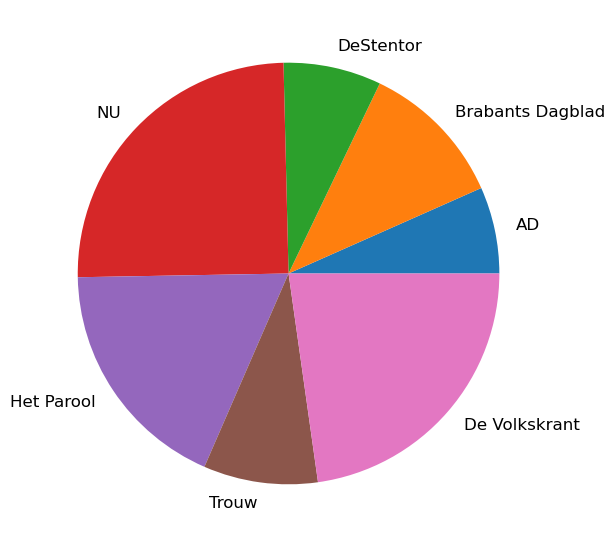

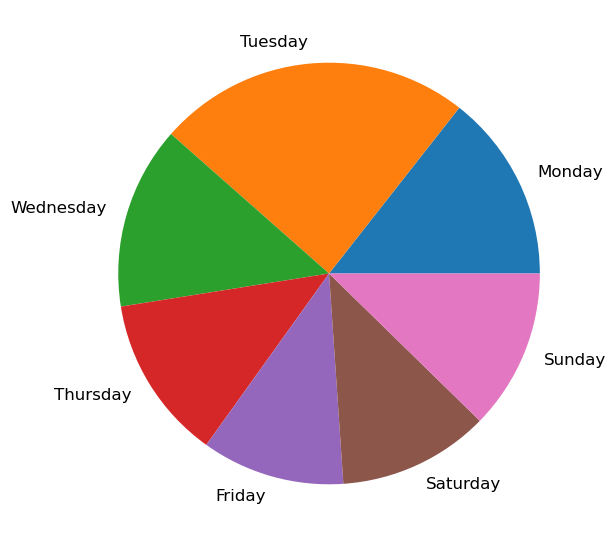

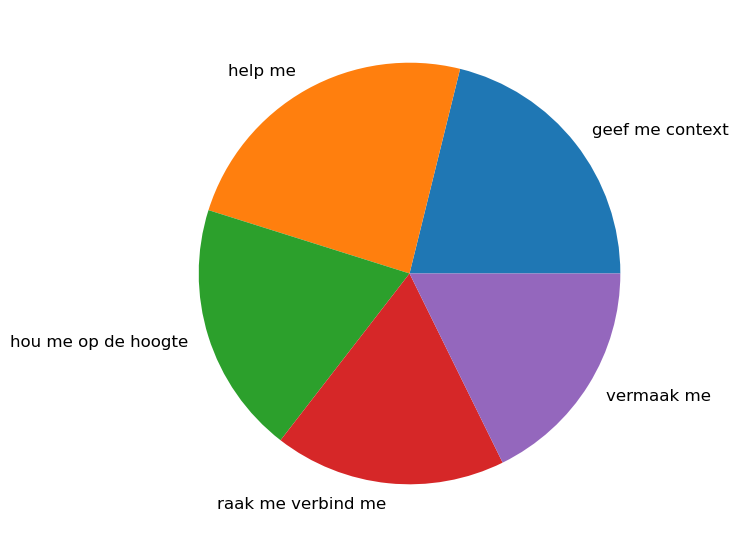

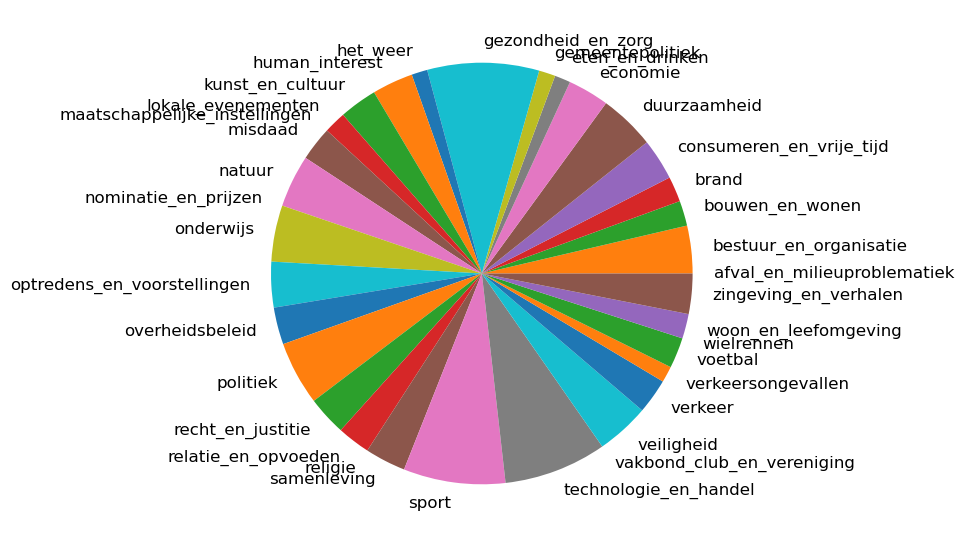

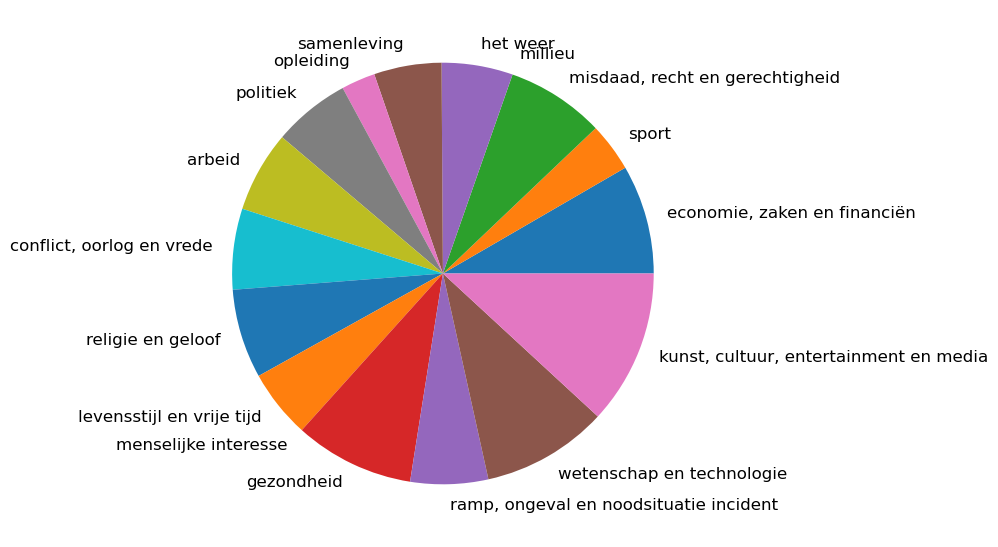

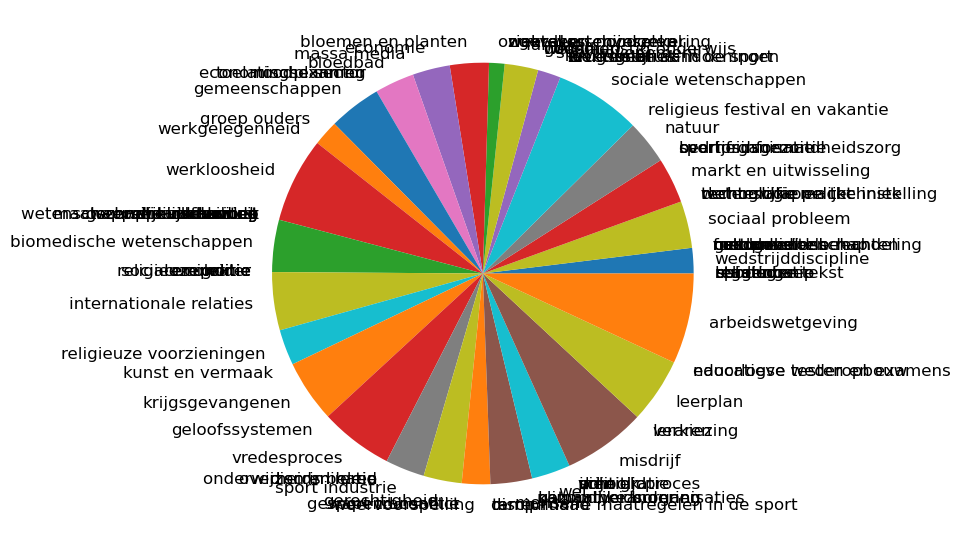

In [138]:
brands_in_csv_filename = [
    "AD",
    "Brabants Dagblad",
    "DeStentor",
    "NU",
    "Het Parool",
    "Trouw",
    "De Volkskrant",
]
weekdays = [
	'Monday',
	'Tuesday',
	'Wednesday',
	'Thursday',
	'Friday',
	'Saturday',
	'Sunday'
]
user_needs=[
	'geef me context',
	'help me',
	'hou me op de hoogte',
	'raak me verbind me',
	'vermaak me'
]
LDA_topics = [
	'afval_en_milieuproblematiek', 
	'bestuur_en_organisatie',
	'bouwen_en_wonen',
	'brand',
	'consumeren_en_vrije_tijd',
	'duurzaamheid',
	'economie',
	'eten_en_drinken',
	'gemeentepolitiek',
	'gezondheid_en_zorg',
	'het_weer',
	'human_interest',
	'kunst_en_cultuur',
	'lokale_evenementen',
	'maatschappelijke_instellingen',
	'misdaad',
	'natuur',
	'nominatie_en_prijzen',
	'onderwijs',
	'optredens_en_voorstellingen',
	'overheidsbeleid',
	'politiek',
	'recht_en_justitie',
	'relatie_en_opvoeden',
	'religie',
	'samenleving',
	'sport',
	'technologie_en_handel',
	'vakbond_club_en_vereniging',
	'veiligheid',
	'verkeer',
	'verkeersongevallen',
	'voetbal',
	'wielrennen',
	'woon_en_leefomgeving',
	'zingeving_en_verhalen'
]

iptc_0_topics = [
	'economie, zaken en financiën',
	'sport',
	'misdaad, recht en gerechtigheid',
	'millieu',
	'het weer',
	'samenleving',
	'opleiding',
	'politiek',
	'arbeid',
	'conflict, oorlog en vrede',
	'religie en geloof',
	'levensstijl en vrije tijd',
	'menselijke interesse',
	'gezondheid',
	'ramp, ongeval en noodsituatie incident',
	'wetenschap en technologie',
	'kunst, cultuur, entertainment en media'
]

iptc_1_topics = ['wedstrijddiscipline', 'fundamentele rechten', 'mensheid', 'natuurwetenschap', 'cultuur', 'met pensioen', 'gezondheidsbehandeling', 'noodgeval', 'sociaal probleem', 'rechterlijke macht', 'technologie en techniek', 'wetenschappelijke instelling', 'demografie', 'markt en uitwisseling', 'sportorganisatie', 'overheidsgezondheidszorg', 'bedrijfsinformatie', 'natuur', 'religieus festival en vakantie', 'sociale wetenschappen', 'drugsgebruik in de sport', 'levensstijl', 'ziekten en aandoeningen', 'werk relaties', 'sport evenement', 'noodhulp', 'welzijn', 'godsdienstig onderwijs', 'familie', 'waarden', 'weersverschijnselen', 'ziektekostenverzekering', 'ongeval en noodgeval', 'bloemen en planten', 'economie', 'massa media', 'bloedbad', 'noodplanning', 'economische sector', 'toelatingsexamen', 'gemeenschappen', 'groep ouders', 'werkgelegenheid', 'werkloosheid', 'vakbonden', 'medisch beroep', 'weerswaarschuwing', 'wetenschappelijk onderzoek', 'maatschappelijke onrust', 'milieuvervuiling', 'gezondheidsfaciliteit', 'wiskunde', 'biomedische wetenschappen', 'religieuze leider', 'sociale conditie', 'politie', 'emigratie', 'ceremonie', 'internationale relaties', 'religieuze voorzieningen', 'kunst en vermaak', 'krijgsgevangenen', 'geloofssystemen', 'vredesproces', 'onderwijzen en leren', 'overheids beleid', 'discriminatie', 'sport industrie', 'gerechtigheid', 'sport transactie', 'gewapend conflict', 'weervoorspelling', 'disciplinaire maatregelen in de sport', 'ramp', 'terreurdaad', 'mensen', 'natuurlijke bronnen', 'klimaatverandering', 'gezondheidsorganisaties', 'wet', 'immigratie', 'school', 'politiek proces', 'dier', 'vrije tijd', 'misdrijf', 'leraren', 'verkiezing', 'leerplan', 'naoorlogse wederopbouw', 'educatieve testen en examens', 'arbeidswetgeving', 'studenten', 'religieuze tekst', 'sportlocatie', 'behoud', 'staatsgreep', 'regering']

errors = [(a.item(),b.numpy(),c.item(),d.item(), e) for (a,b,c,d,e) in zip(metric_score_test, dataset[test_dataset_indices][0].cpu(), y_test, y_pred_test, test_dataset_indices)]
#errors = [(a.item(),b.numpy(),c.item(),d.item(), e) for (a,b,c,d,e) in zip(metric_score_test_forest, dataset[test_dataset_indices_forest][0].cpu(), y_test_forest, y_pred_test_forest, test_dataset_indices_forest)]

errors.sort(reverse=True, key=lambda x: x[0])

brand_all_indices = [0 for _ in range(7)]
weekday_all_indices = [0 for _ in range(7)]
user_needs_all_indices = [0 for _ in range(5)]
LDA_all_indices = [0 for _ in range(36)]
iptc_0_all_indices = [0 for _ in range(17)]
iptc_1_all_indices = [0 for _ in range(98)]
for err in errors[:22000]:
	brand_all_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_all_indices[brand_all_index] += 1
	weekday_all_index, _ = max(enumerate(err[1][9:16]), key=lambda x: x[1])
	weekday_all_indices[weekday_all_index] += 1
	user_needs_all_index, _ = max(enumerate(err[1][618:623]), key=lambda x: x[1])
	user_needs_all_indices[user_needs_all_index] += 1
	LDA_all_index, _ = max(enumerate(err[1][623:659]), key=lambda x: x[1])
	LDA_all_indices[LDA_all_index] += 1
	iptc_0_all_index, _ = max(enumerate(err[1][659:676]), key=lambda x: x[1])
	iptc_0_all_indices[iptc_0_all_index] += 1
	iptc_1_all_index, _ = max(enumerate(err[1][676:774]), key=lambda x: x[1])
	iptc_1_all_indices[iptc_1_all_index] += 1


print("brands:")
for i in range(len(brand_all_indices)):
	print(f"{i}.{brands_in_csv_filename[i]}: {brand_all_indices[i]}")
print()
print("weekdays:")
for i in range(len(weekday_all_indices)):
	print(f"{i}.{weekdays[i]}: {weekday_all_indices[i]}")
print()
print("user_needs:")
for i in range(len(user_needs_all_indices)):
	print(f"{i}.{user_needs[i]}: {user_needs_all_indices[i]}")
print()
print("LDA_topics:")
for i in range(len(LDA_all_indices)):
	print(f"{i}.{LDA_topics[i]}: {LDA_all_indices[i]}")
print()
print("iptc_0_topics:")
for i in range(len(iptc_0_all_indices)):
	print(f"{i}.{iptc_0_topics[i]}: {iptc_0_all_indices[i]}")
print()
print("iptc_1_topics:")
for i in range(len(iptc_1_all_indices)):
	print(f"{i}.{iptc_1_topics[i]}: {iptc_1_all_indices[i]}")

brand_max_indices = [0 for _ in range(7)]
weekday_max_indices = [0 for _ in range(7)]
user_needs_max_indices = [0 for _ in range(5)]
LDA_max_indices = [0 for _ in range(36)]
iptc_0_max_indices = [0 for _ in range(17)]
iptc_1_max_indices = [0 for _ in range(98)]

for err in errors[:300]:
	#print(f"Error: {err[0]:.4f}, True Value: {err[2]:.4f}, Predicted: {err[3]:.4f}, Index: {err[4]:.4f}")
	brand_max_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_max_indices[brand_max_index] += 1
	weekday_max_index, _ = max(enumerate(err[1][9:16]), key=lambda x: x[1])
	weekday_max_indices[weekday_max_index] += 1
	user_needs_max_index, _ = max(enumerate(err[1][618:623]), key=lambda x: x[1])
	user_needs_max_indices[user_needs_max_index] += 1
	LDA_max_index, _ = max(enumerate(err[1][623:659]), key=lambda x: x[1])
	LDA_max_indices[LDA_max_index] += 1
	iptc_0_max_index, _ = max(enumerate(err[1][659:676]), key=lambda x: x[1])
	iptc_0_max_indices[iptc_0_max_index] += 1
	iptc_1_max_index, _ = max(enumerate(err[1][676:774]), key=lambda x: x[1])
	iptc_1_max_indices[iptc_1_max_index] += 1

print(iptc_0_max_indices[13])
print(iptc_0_max_indices[15])
LDA_max_indices = [0 if LDA_all_indices[i] < 100 else LDA_max_indices[i] for i in range(len(LDA_max_indices))]
iptc_0_max_indices = [0 if iptc_0_all_indices[i] < 100 else iptc_0_max_indices[i] for i in range(len(iptc_0_max_indices))]
iptc_1_max_indices = [0 if iptc_1_all_indices[i] < 100 else iptc_1_max_indices[i] for i in range(len(iptc_1_max_indices))]

brand_max_indices = [brand_max_indices[i] / brand_all_indices[i] for i in range(7)]
weekday_max_indices = [weekday_max_indices[i] / weekday_all_indices[i] for i in range(7)]
user_needs_max_indices = [user_needs_max_indices[i] / user_needs_all_indices[i] for i in range(5)]
LDA_max_indices = [LDA_max_indices[i] / LDA_all_indices[i] if LDA_all_indices[i] != 0 else 0 for i in range(36)]
iptc_0_max_indices = [iptc_0_max_indices[i] / iptc_0_all_indices[i] if iptc_0_all_indices[i] != 0 else 0 for i in range(17)]
iptc_1_max_indices = [iptc_1_max_indices[i] / iptc_1_all_indices[i] if iptc_1_all_indices[i] != 0 else 0 for i in range(98)]

brand_max_indices = [(brand_max_indices[i] / sum(brand_max_indices)) * 100 for i in range(7)]
weekday_max_indices = [(weekday_max_indices[i] / sum(weekday_max_indices)) * 100 for i in range(7)]
user_needs_max_indices = [(user_needs_max_indices[i] / sum(user_needs_max_indices)) * 100 for i in range(5)]
LDA_max_indices = [(LDA_max_indices[i] / sum(LDA_max_indices)) * 100 for i in range(36)]
iptc_0_max_indices = [(iptc_0_max_indices[i] / sum(iptc_0_max_indices)) * 100 for i in range(17)]
iptc_1_max_indices = [(iptc_1_max_indices[i] / sum(iptc_1_max_indices)) * 100 for i in range(98)]

plt.pie(brand_max_indices, labels=brands_in_csv_filename)
plt.show()

weekday_max_indices_s = weekday_max_indices[-2:] + weekday_max_indices[:-2]
plt.pie(weekday_max_indices_s, labels=weekdays)
plt.show()

plt.pie(user_needs_max_indices, labels=user_needs)
plt.show()

plt.pie(LDA_max_indices, labels=LDA_topics)
plt.show()

plt.pie(iptc_0_max_indices, labels=iptc_0_topics)
plt.show()

plt.pie(iptc_1_max_indices, labels=iptc_1_topics)
plt.show()